In [1]:
import librosa
import numpy as np
import pandas as pd
import ast
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew, kurtosis


In [2]:
def calc_stats(feature):
        return np.hstack([
            np.mean(feature), np.var(feature), np.std(feature),
            np.median(feature), np.max(feature), 
            np.min(feature), skew(feature), 
            kurtosis(feature),
        ])

def extract_features(audio_file):

        # Load the audio file using librosa
        y, sr = librosa.load(audio_file, sr=None, mono=True)

        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
        #alla 20 på mfcc
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        
        chroma_stats = []
        for i in range(chroma_stft.shape[0]):
            chroma_stats.append(calc_stats(chroma_stft[i, :]))  
        chroma_stats = np.hstack(chroma_stats)
        #print(f"Chroma STFT Shape: {chroma_stft.shape}")
        #print(f"Chroma STFT stats Shape: {chroma_stats.shape}")

        spectral_centroid_stats = calc_stats(np.hstack(spectral_centroid))
        #print(f"Spectral Centroid  Shape: {spectral_centroid.shape}")
        #print(f"Spectral Centroid stats  Shape: {spectral_centroid_stats.shape}")


        spectral_contrast_stats = []
        for i in range(spectral_contrast.shape[0]):
            spectral_contrast_stats.append(calc_stats(spectral_contrast[i, :])) 
        spectral_contrast_stats = np.hstack(spectral_contrast_stats)
        #print(f"Spectral Contrast Shape: {spectral_contrast.shape}")
        #print(f"Spectral Contrast stats Shape: {spectral_contrast_stats.shape}")

        zero_crossing_stats = calc_stats(np.hstack(zero_crossing_rate))
        #print(f"Zero Crossing Rate Shape: {zero_crossing_rate.shape}")
        #print(f"Zero Crossing Rate stast Shape: {zero_crossing_stats.shape}")


        mfcc_stats = []
        for i in range(mfccs.shape[0]):
            mfcc_stats.append(calc_stats(mfccs[i, :]))  

        mfcc_stats = np.hstack(mfcc_stats)
        #print(f"MFCC Stats Shape: {mfccs.shape}")
        #print(f"MFCC Stats stats Shape: {mfcc_stats.shape}")

        

        

        
        # Aggregate each feature into mean and variance
        features =np.hstack( [
            chroma_stats,
            spectral_centroid_stats,
            spectral_contrast_stats,
            zero_crossing_stats,
            mfcc_stats])

      
        #print(f"Final Features Shape: {features.shape}")
        return np.array(features)

  


In [3]:
# The code from fma https://github.com/mdeff/fma/blob/master/utils.py#L183
def load_tracks(filepath):
    if 'tracks' in filepath:
        # Load tracks.csv
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        
        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

       
        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [4]:
audio_dir='fma_small'

feature_extraction_test = extract_features('fma_small/000/000002.mp3')

filepath = 'fma_small/fma_metadata/tracks.csv'
tracks = load_tracks(filepath)
fma_small = tracks[tracks['set', 'subset'] == 'small']

# Print the shape of the small subset
print(fma_small.shape)

(8000, 52)


In [5]:
audio_dir='fma_small'

feature_extraction_test = extract_features('fma_small/000/000002.mp3')

filepath = 'fma_small/fma_metadata/tracks.csv'
tracks = load_tracks(filepath)
fma_small = tracks[tracks['set', 'subset'] == 'small']

# Print the shape of the small subset
print(fma_small.shape)

(8000, 52)


In [6]:
'''
import time
X = []
y = []

# Extract features for each track in fma_small
for idx, row in fma_small.iterrows():
    #start_time = time.time()

    track_id = row.name 
    genre_label = row[('track', 'genre_top')]  
    
    # Construct the file path
    directory = '{:03d}'.format(track_id // 1000)
    filename = '{:06d}.mp3'.format(track_id)
    file_path = os.path.join(audio_dir, directory, filename)
    
    try:
        features = extract_features(file_path)
        X.append(features)
        y.append(genre_label)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    if idx % 1000 == 0 and idx != 0:
            print(f"Processed {idx} files so far")
    #elapsed_time = time.time() - start_time
    #print(elapsed_time)


# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

np.save('X.npy', X)
np.save('y.npy', y)
 '''

'\nimport time\nX = []\ny = []\n\n# Extract features for each track in fma_small\nfor idx, row in fma_small.iterrows():\n    #start_time = time.time()\n\n    track_id = row.name \n    genre_label = row[(\'track\', \'genre_top\')]  \n    \n    # Construct the file path\n    directory = \'{:03d}\'.format(track_id // 1000)\n    filename = \'{:06d}.mp3\'.format(track_id)\n    file_path = os.path.join(audio_dir, directory, filename)\n    \n    try:\n        features = extract_features(file_path)\n        X.append(features)\n        y.append(genre_label)\n    except Exception as e:\n        print(f"Error processing {file_path}: {e}")\n    if idx % 1000 == 0 and idx != 0:\n            print(f"Processed {idx} files so far")\n    #elapsed_time = time.time() - start_time\n    #print(elapsed_time)\n\n\n# Convert lists to numpy arrays\nX = np.array(X)\ny = np.array(y)\n\nnp.save(\'X.npy\', X)\nnp.save(\'y.npy\', y)\n '

In [7]:
# Load X and y from the saved .npy files

XX = np.load('X.npy', allow_pickle=True)
yy = np.load('y.npy', allow_pickle=True)


In [9]:


# (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2, random_state=42, stratify=yy)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



X_train shape: (6395, 328), y_train shape: (6395,)
X_test shape: (1599, 328), y_test shape: (1599,)


In [14]:
from sklearn.model_selection import cross_val_score


clf = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf=1, bootstrap=True)

scores = cross_val_score(clf, X_train, y_train)
print(f"Cross-validation accuracy: {scores.mean():.4f}")
#Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
clf.fit(X_train, y_train)


Cross-validation accuracy: 0.5204


RandomForestClassifier(min_samples_split=5, n_estimators=500)

In [15]:


# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 52.72%
Classification Report:
               precision    recall  f1-score   support

   Electronic       0.50      0.53      0.51       200
 Experimental       0.56      0.36      0.44       200
         Folk       0.62      0.69      0.66       200
      Hip-Hop       0.53      0.63      0.58       199
 Instrumental       0.55      0.63      0.59       200
International       0.58      0.52      0.54       200
          Pop       0.31      0.23      0.27       200
         Rock       0.53      0.62      0.57       200

     accuracy                           0.53      1599
    macro avg       0.52      0.53      0.52      1599
 weighted avg       0.52      0.53      0.52      1599



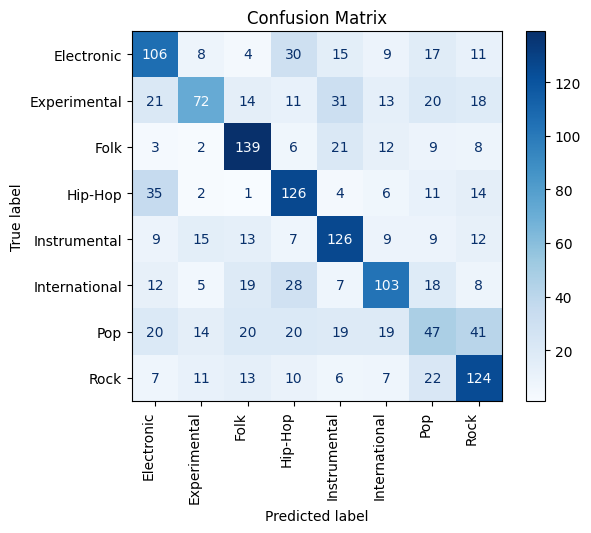

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

class_names = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',  'Pop', 'Rock']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, ha='right')
plt.title("Confusion Matrix")
plt.show()


In [18]:
def classify_genre(audio_path):
    
    features = extract_features(audio_path) 
    features = features.reshape(1, -1)
    genre= clf.predict(features)[0]
    return genre

d = classify_genre('fma_small/000/000694.mp3')
print(d)

Hip-Hop
